In [2]:
import pandas as pd
import numpy as np
import spacy
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import re
from wordcloud import WordCloud
import itertools
import collections
import nltk
import string
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
import multiprocessing
from gensim.models import Word2Vec
from multiprocessing import Process
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
import sklearn
from sklearn.cluster import KMeans

###Data Import

In [ ]:
# import the data
tweets = pd.read_csv('tweets.csv')
#tweets = pd.read_csv('tweetsGPT4sentiments.csv')

In [ ]:
tweets.head()

,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,hashtags,source
0,2023-04-12 20:05:08+00:00,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android
1,2023-04-12 20:05:06+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android
2,2023-04-12 20:05:04+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android
3,2023-04-12 20:05:02+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android
4,2023-04-12 20:04:58+00:00,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z9J",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android


In [ ]:
len(tweets.columns.tolist())

12

In [ ]:
# for plotting missing values

def return_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()/len(data_frame)
    missing_values = missing_values[missing_values>0]
    missing_values.sort_values(inplace=True)
    return missing_values

def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='darkgrid')
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.title('Missing Values Fraction for Columns')
    plt.show()
    
    
#https://github.com/ShilpiParikh/EDA-on-COVID-19-tweets/blob/main/Covid19_tweets_EDA%20.ipynb

In [ ]:
return_missing_values(tweets)

user_name           0.000035
hashtags            0.182306
user_description    0.394741
user_location       0.523406
dtype: float64

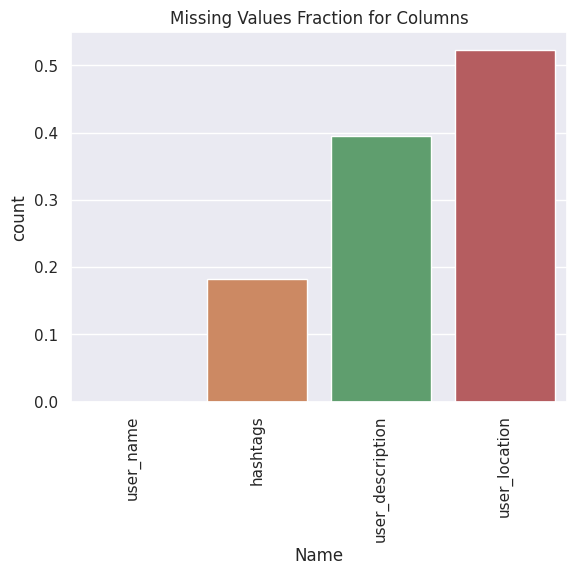

In [ ]:
plot_missing_values(tweets)

###Preprocessing

In [ ]:
len(tweets)

28710

In [ ]:
# drop duplicate rows with subset on text column
tweets=tweets.drop_duplicates(subset=['text'])

In [ ]:
len(tweets[tweets['text'].str.contains("GPT4|GPT-4|gpt4|GPT4|Gpt4|Gpt-4|gpt 4|GPT 4")==True])

28328

In [ ]:
# leave only tweets where there is GPT4 mentioned in either hashtags or raw text
tweets = tweets[tweets['text'].str.contains("GPT4|GPT-4|gpt4|GPT4|Gpt4|Gpt-4|gpt 4|GPT 4")==True]
len(tweets)

28704

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# the function to clean the tweet and tokenize them
def clean_tweet(tweet):
    if type(tweet) == float:
            return ""

    # turn text into lower
    test = tweet.lower()
    # remove all mentions and hashtags 
    test = re.sub("@[A-Za-z0-9_]+","", test)
    test = re.sub("#[A-Za-z0-9_]+","", test)
    #remove links
    test = re.sub(r"http\S+", "", test)
    test = re.sub(r"www.\S+", "", test)
    #remove punctuation
    test = re.sub('[()!?]', ' ', test)
    test = re.sub('\[.*?\]',' ', test)
    #remove non alphabetical characters
    test = re.sub("[^a-z0-9]"," ", test)
    #remove extra spaces
    test = re.sub(' +', ' ', test)
    # remove single letter words
    test = ' '.join( [w for w in test.split() if len(w)>1] )
    
    test = ' '.join( [lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(test) if x not in stop_words])
    test =[lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(test) if x not in stop_words]

    return test

In [ ]:
clean_tweet(tweets['text'].iloc[3])

['neuroni',
 'want',
 'neuroni',
 'ai',
 'telegram',
 'group',
 'choose',
 'premium',
 'subscription',
 'unlimited',
 'request',
 'priority',
 'access',
 'update']

In [ ]:
# clean the tweets and create two columns: tokenized tweet and whole tweet
tweets["tweet_tokens"]=tweets["text"].apply(lambda x:clean_tweet(x))
tweets["cleaned_tweet"]=tweets["tweet_tokens"].apply(lambda x:' '.join(x))

In [ ]:
tweets['cleaned_tweet'].iloc[6]

'neuroni need code specific program language neuroni ai create demand include decipher cryptographic cipher'

In [ ]:
tweets = tweets.drop_duplicates(subset=['cleaned_tweet'])

In [ ]:
# clean all the tweets with NFT in them
tweets = tweets[tweets['cleaned_tweet'].str.contains("NFT|nft|Nft")==False]
len(tweets)

20465

In [ ]:
# creatr another dataset for test, with only tweets that contain gpt4 as a word
tweets_gpt = tweets[tweets['cleaned_tweet'].str.contains("GPT4|GPT-4|gpt4|GPT4|Gpt4|Gpt-4|gpt 4|GPT 4")==True]
tweets_gpt.head()

In [ ]:
tweets.shape

(20465, 15)

In [ ]:
tweets_gpt['tweet_tokens'][10:15]

349    [least, instance, bard, way, base, gpt4, ask, ...
377    [day, 10, roundup, unmissable, innovation, aut...
393    [title, power, ai, clarity, mind, unlock, full...
395    [fascinate, qualitative, discussion, intellige...
434      [ray, kurzweil, wrong, signularity, chat, gpt4]
Name: tweet_tokens, dtype: object

###Tweets embeddings

In [ ]:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Converting the "clean_tweet" column in the format supported by embeddings.
sent = [row for row in tweets["tweet_tokens"]]
#use Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
phrases = Phrases(sent, min_count=1, progress_per=5000)
bigram = gensim.models.phrases.Phraser(phrases)
sentences = bigram[sent]
sentences[1]

# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial 

['neuroni',
 'invest',
 'neuroni',
 'part',
 'project',
 'reserve',
 'total',
 'supply',
 '10m',
 'token',
 'dev',
 'token']

In [ ]:
len(sentences)

20465

###Word2dvec Model

In [ ]:
#Initializing the word2vec model
w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


#building vocab of the word2vec model from the custom data
w2v_model.build_vocab(sentences, progress_per=5000)

# https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483

In [ ]:
#training the word2vec model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=60, report_delay=1)

(2599887, 13413300)

In [ ]:
w2v_model.wv.most_similar(positive =["ai"])

[('shape', 0.9706013202667236),
 ('unleash_power', 0.9700911641120911),
 ('web_development', 0.969957709312439),
 ('twitter_thread', 0.9697667360305786),
 ('society', 0.969677746295929),
 ('introduce', 0.9696319699287415),
 ('get_ready', 0.9692681431770325),
 ('could_revolutionize', 0.9691582918167114),
 ('diverse', 0.9690331220626831),
 ('effect', 0.9688423275947571)]

In [ ]:
#saving the word2vec model
w2v_model.save("word2vec2.model")

In [ ]:
#Loading the word2vec model
word_vectors = Word2Vec.load("word2vec2.model").wv

###Clustering

In [ ]:
#Feeding the embeddings to a KMeans model to cluster words into positive, negative, and neutral clusters
model = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [ ]:
# check what we have in each cluster to label the clusters
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=200, restrict_vocab=None)

In [ ]:
# Labelling the clusters based on the type of words they carry
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[2]
neutral_cluster_center= model.cluster_centers_[1]

In [ ]:
#Creating a DataFrame of words with their embeddings and cluster values
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

# https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483

In [ ]:
words

In [ ]:
#Assigning 1 to positive values, 0 to neutral and -1 for negative values
words['cluster_value'] = [1 if i==0 else 0 if i==1 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [ ]:
# observe the resulting clusters to see if they make sense
with pd.option_context('display.max_rows', None,):
    print(words[words["cluster_value"]==0][:100].sort_values("closeness_score"))

In [ ]:
# manually redistribute the words to appropriate clusters after observing them in previous cell
positive = ['amaze','excite','better','powerful','good', 'useful_response', 'excite_news', 'triple_productivity', 'powerful_dominate', 'beauty']
neutral = []
negative= ['call_pause', 'gpt4_fuck', 'risk_society', 'month_pause']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"]=1
    
for i in neutral:
    words.loc[words["words"]==i,"cluster_value"]=0
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"]=-1

In [ ]:
words[words["words"]=="dangerous"]

,words,vectors,cluster,cluster_value,closeness_score
950,dangerous,"[0.06394868, -0.12075806, 0.03379083, -0.15849613, -0.007379439, -0.041204378, 0.2061619, -0.09428316, 0.17680627, 0.102316566, 0.18570419, 0.108009264, 0.028006272, 0.13245699, -0.052746747, -0.08798907, 0.19906381, -0.03073499, 0.028859477, -0.1185326, 0.14732711, -0.036823884, 0.0070893243, 0.0044922875, 0.01269972, 0.09770313, -0.057602182, 0.06488682, 0.08542414, 0.04983047, 0.079991184, -0.024440076, -0.01615183, 0.08424596, 0.092317924, 0.13017476, 0.006356031, -0.14467077, -0.13982107, -0.08845274, 0.04191489, 0.215474, -0.12408582, 0.030086866, -0.026422339, 0.121005096, 0.048447773, -0.05364643, 0.1220707, 0.03590949, 0.05759167, -0.081410274, 0.0920113, 0.028770877, 0.0004995223, -0.017601795, -0.17500018, 0.010164062, 0.096610114, -0.013940563, -0.032680657, 0.06483406, 0.05814439, 0.3432126, -0.050533466, 0.101596, -0.00294172, 0.19237246, -0.026790328, 0.19825141, -0.08467871, -0.038883664, 0.06704717, 0.060492247, 0.0011585644, -0.032668836, -0.01801571, -0.023749184, -0.10688852, 0.05696195, 0.266794, 0.0026026482, 0.059255052, 0.029388813, 0.23744984, 0.08402649, -0.090232834, 0.08292756, -0.054546807, -0.04877713, -0.08120561, 0.015356117, 0.04093758, -0.053559102, 0.077600725, 0.043759305, -0.018697081, 0.06863834, 0.11292903, 0.003068052, ...]",2,-1,7.472938


### Sentiment analysis of words 

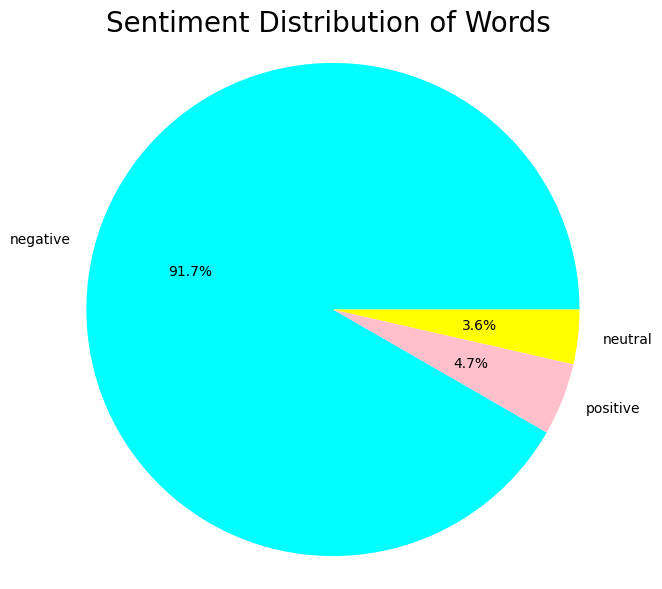

,index,sentiments
0,negative,5120
1,positive,265
2,neutral,199


In [ ]:
# Plotting pie chart of Sentiment Distribution of words
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

words["sentiments"]=words["cluster_value"].map(emotion)


fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"],labels=df_pie["index"],radius=2,colors=colors,autopct="%1.1f%%")
plt.axis('equal')
plt.title("Sentiment Distribution of Words ", fontsize=20)
plt.show()
df_pie

### Sentiment analysis of whole tweets

In [ ]:
# creating a dictionary of the word and its cluster value
words_dict = dict(zip(words.words, words.cluster_value))

In [ ]:
# define a function to get the sentiment for the entire tweet
def get_sentiments(x,words_dict):
    
    total=0
    count=0
    test=x["tweet_tokens"]
    #print(test)
    for t in test:
        if words_dict.get(t):
            total+=int(words_dict.get(t))
            #print('adding', int(words_dict.get(t)))
        count+=1
    if count == 0:
        sentiment = 'no data'
    else:
        avg=total/count
        sentiment=-1 if avg<-0.15 else 1 if avg >0.15 else 0
    return sentiment

In [ ]:
tweets['sentiment'] = np.nan

for i in range(len(tweets)):
    x = tweets.iloc[i]
    tweets['sentiment'][i] = get_sentiments(x, words_dict)

In [ ]:
tweets.head()

In [ ]:
# checking the value counts of each sentiment
tweets["sentiment"].value_counts()

-1.0       12541
0.0        561  
1          40   
no data    1    
Name: sentiment, dtype: int64

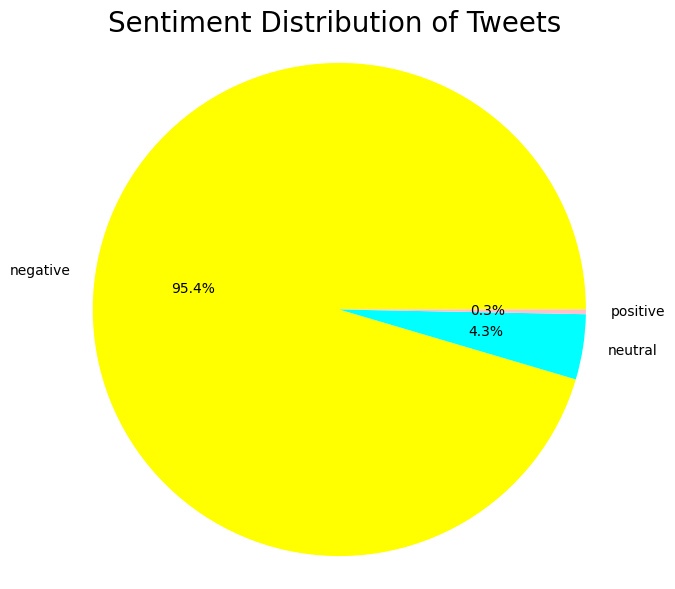

,index,sentiments_val
0,negative,12541
1,neutral,561
2,positive,40


In [ ]:
# Plotting pie chart of Sentiment Distribution of tweets
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}
tweets["sentiments_val"]=tweets["sentiment"].map(emotion)
data_pie=tweets["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["yellow","cyan","pink"]
plt.pie(data_pie["sentiments_val"],labels=data_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Sentiment Distribution of Tweets ", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
data_pie

In [ ]:
# some positive tweets
list(tweets[tweets["sentiment"]==-1]["cleaned_tweet"][400:500])

### VADER 

In [ ]:
# import the sentiment analyzer 
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# run some tests to make sure everything works and makes sense
cl_tweet = tweets['cleaned_tweet'].iloc[150]
cl_tweet

'imagine landscape gpt get extremely interest people see significant advantage use assistant moment ai human powerful space right however develop rapidly'

In [ ]:
tweets = tweets[tweets['cleaned_tweet'].notna()]

In [ ]:
len(tweets)

20465

In [ ]:
sid.polarity_scores(cl_tweet)

{'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'compound': 0.8357}

In [ ]:
# apply the polarity scores function from the VADER package onto cleaned_tweet column
tweets['sentiments_vader'] = tweets['cleaned_tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

tweets.head()

,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,hashtags,source,TweetOrig,tweet_tokens,cleaned_tweet,sentiment,sentiments_val,sentiments_vader
0,2023-04-12 20:05:08+00:00,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,"[neuroni, join, official, telegram, group, stay, tune, latest, neuroni, ai, update, news]",neuroni join official telegram group stay tune latest neuroni ai update news,-1.0,negative,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.296}"
1,2023-04-12 20:05:06+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni","[neuroni, invest, neuroni, part, project, reserve, total, supply, 10m, token, dev, token]",neuroni invest neuroni part project reserve total supply 10m token dev token,-1.0,negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,2023-04-12 20:05:04+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni","[neuroni, get, ready, neuroni, ai, bot, available, free, feature, phase, roadmap]",neuroni get ready neuroni ai bot available free feature phase roadmap,-1.0,negative,"{'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.7003}"
3,2023-04-12 20:05:02+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni","[neuroni, want, neuroni, ai, telegram, group, choose, premium, subscription, unlimited, request, priority, access, update]",neuroni want neuroni ai telegram group choose premium subscription unlimited request priority access update,-1.0,negative,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.0772}"
4,2023-04-12 20:04:58+00:00,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z9J",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z

In [ ]:
# calculate the comound VADER score for every tweet
tweets['compound']  = tweets['sentiments_vader'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
# turn VADER numeric output into clusters for better interpretation (one of the ways)
def sentimentPredict(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05: 
        return "negative"
    else:
        return "neutral"

In [ ]:
# calculate the compound VADER score for every tweets by mapping the function from the previous cell
tweets['sentiment_vader'] =tweets['compound'].apply(lambda x: sentimentPredict(x))
tweets.head(5)

,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,hashtags,source,TweetOrig,tweet_tokens,cleaned_tweet,sentiment,sentiments_val,sentiments_vader,compound,sentiment_vader
0,2023-04-12 20:05:08+00:00,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,"[neuroni, join, official, telegram, group, stay, tune, latest, neuroni, ai, update, news]",neuroni join official telegram group stay tune latest neuroni ai update news,-1.0,negative,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.296}",0.2960,positive
1,2023-04-12 20:05:06+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni","[neuroni, invest, neuroni, part, project, reserve, total, supply, 10m, token, dev, token]",neuroni invest neuroni part project reserve total supply 10m token dev token,-1.0,negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
2,2023-04-12 20:05:04+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni","[neuroni, get, ready, neuroni, ai, bot, available, free, feature, phase, roadmap]",neuroni get ready neuroni ai bot available free feature phase roadmap,-1.0,negative,"{'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.7003}",0.7003,positive
3,2023-04-12 20:05:02+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni","[neuroni, want, neuroni, ai, telegram, group, choose, premium, subscription, unlimited, request, priority, access, update]",neuroni want neuroni ai telegram group choose premium subscription unlimited request priority access update,-1.0,negative,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.0772}",0.0772,positive
4,2023-04-12 20:04:58+00:00,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z9J",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,NaN,Twitter for Android,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, 

###BERT

In [ ]:
# installing the library 'transformers' which contains BERT implementation
!pip install transformers
 
# installing the library tensorflow
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing the pipeline module
from transformers import pipeline
 
# Downloading the sentiment analysis model
SentimentClassifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
def FunctionBERTSentiment(inpText):
  return(SentimentClassifier(inpText)[0]['label'])

In [ ]:
tweets['cleaned_tweet'].iloc[39]

'thank stay inform latest ai news explain use emojis yes right emojis'

In [ ]:
tweets['text'].iloc[39]

"Thanks to #gpt4, you can now stay informed about the latest AI news by having it explained to you using emojis. Yes that's right, emojis: https://t.co/tnwijlCx2C https://t.co/bo8p6AjjLT"

In [ ]:
FunctionBERTSentiment(tweets['cleaned_tweet'].iloc[39])

'POSITIVE'

In [ ]:
# Calling BERT based sentiment score function for every tweet
tweets['sentiment_bert']=tweets['cleaned_tweet'].apply(FunctionBERTSentiment)
tweets.head(10)

,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,...,source,TweetOrig,tweet_tokens,cleaned_tweet,sentiment,sentiments_val,sentiments_vader,compound,sentiment_vader,sentiment_bert
0,2023-04-12 20:05:08+00:00,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,Twitter for Android,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,"[neuroni, join, official, telegram, group, stay, tune, latest, neuroni, ai, update, news]",neuroni join official telegram group stay tune latest neuroni ai update news,-1.0,negative,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.296}",0.2960,positive,NEGATIVE
1,2023-04-12 20:05:06+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni","[neuroni, invest, neuroni, part, project, reserve, total, supply, 10m, token, dev, token]",neuroni invest neuroni part project reserve total supply 10m token dev token,-1.0,negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NEGATIVE
2,2023-04-12 20:05:04+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni","[neuroni, get, ready, neuroni, ai, bot, available, free, feature, phase, roadmap]",neuroni get ready neuroni ai bot available free feature phase roadmap,-1.0,negative,"{'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.7003}",0.7003,positive,NEGATIVE
3,2023-04-12 20:05:02+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,Twitter for Android,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni","[neuroni, want, neuroni, ai, telegram, group, choose, premium, subscription, unlimited, request, priority, access, update]",neuroni want neuroni ai telegram group choose premium subscription unlimited request priority access update,-1.0,negative,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.0772}",0.0772,positive,NEGATIVE
4,2023-04-12 20:04:58+00:00,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z9J",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,Twitter for Android,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderati

In [ ]:
tweets['sentiment_bert'] = tweets['sentiment_bert'].str.lower()

### Sentiment Analysis comparison

In [ ]:
# turn all the sentiment numbers to words
def sentimentBack(score):
    if score == 1:
        return 'positive'
    elif score == -1: 
        return 'negative'
    else:
        return 'neutral'

In [ ]:
# apply the function from the previous cell to create results column for the Kmeans algoirithm
# we turn it into words for better interpreation by visualizations
tweets['sentiment_kmeans']=tweets['sentiment'].apply(sentimentBack)
tweets.head(10)

,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,...,TweetOrig,tweet_tokens,cleaned_tweet,sentiment,sentiments_val,sentiments_vader,compound,sentiment_vader,sentiment_bert,sentiment_kmeans
0,2023-04-12 20:05:08+00:00,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,"[neuroni, join, official, telegram, group, stay, tune, latest, neuroni, ai, update, news]",neuroni join official telegram group stay tune latest neuroni ai update news,-1.0,negative,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.296}",0.2960,positive,negative,negative
1,2023-04-12 20:05:06+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni","[neuroni, invest, neuroni, part, project, reserve, total, supply, 10m, token, dev, token]",neuroni invest neuroni part project reserve total supply 10m token dev token,-1.0,negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,negative,negative
2,2023-04-12 20:05:04+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni","[neuroni, get, ready, neuroni, ai, bot, available, free, feature, phase, roadmap]",neuroni get ready neuroni ai bot available free feature phase roadmap,-1.0,negative,"{'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.7003}",0.7003,positive,negative,negative
3,2023-04-12 20:05:02+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni","[neuroni, want, neuroni, ai, telegram, group, choose, premium, subscription, unlimited, request, priority, access, update]",neuroni want neuroni ai telegram group choose premium subscription unlimited request priority access update,-1.0,negative,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.0772}",0.0772,positive,negative,negative
4,2023-04-12 20:04:58+00:00,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z9J",fuari,Cyberspace,beautiful together,2022-12-27 16:50:49+00:00,57,170,446,False,...,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more

In [ ]:
tweets.head(10)

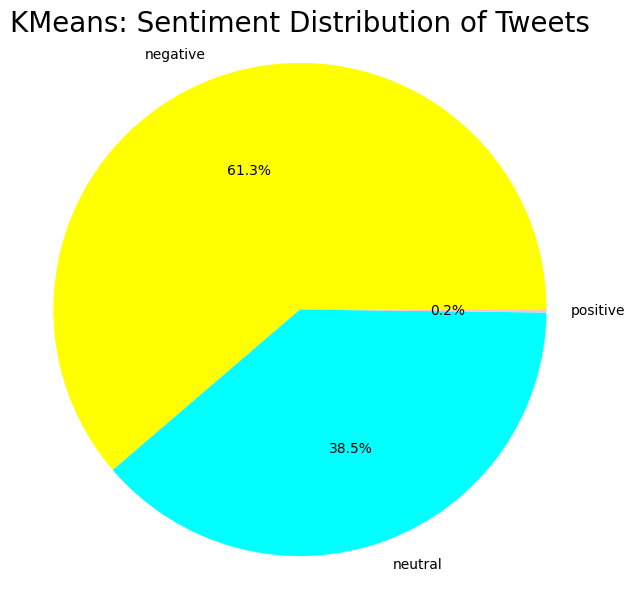

,index,sentiment_kmeans
0,negative,12541
1,neutral,7884
2,positive,40


In [ ]:
# code to create pie chars for the resulting sentiment distributions of the models for comparison


data_pie=tweets["sentiment_kmeans"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["yellow","cyan","pink"]
plt.pie(data_pie["sentiment_kmeans"],labels=data_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("KMeans: Sentiment Distribution of Tweets", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
data_pie

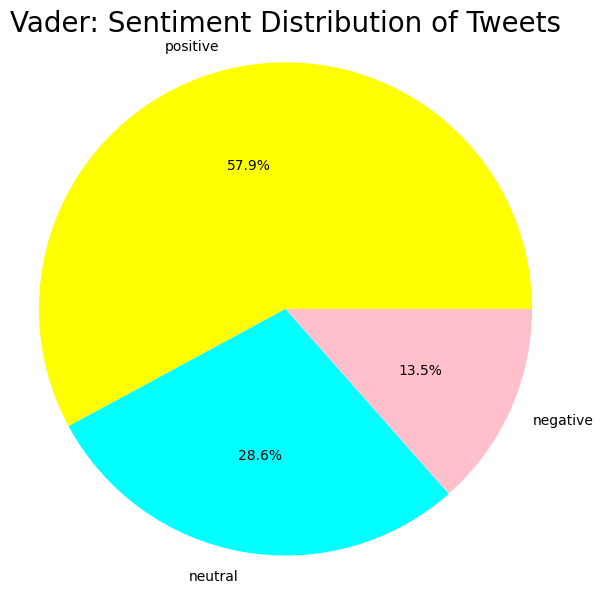

,index,sentiment_vader
0,positive,11847
1,neutral,5858
2,negative,2760


In [ ]:
data_pie=tweets["sentiment_vader"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["yellow","cyan","pink"]
plt.pie(data_pie["sentiment_vader"],labels=data_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Vader: Sentiment Distribution of Tweets", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
data_pie

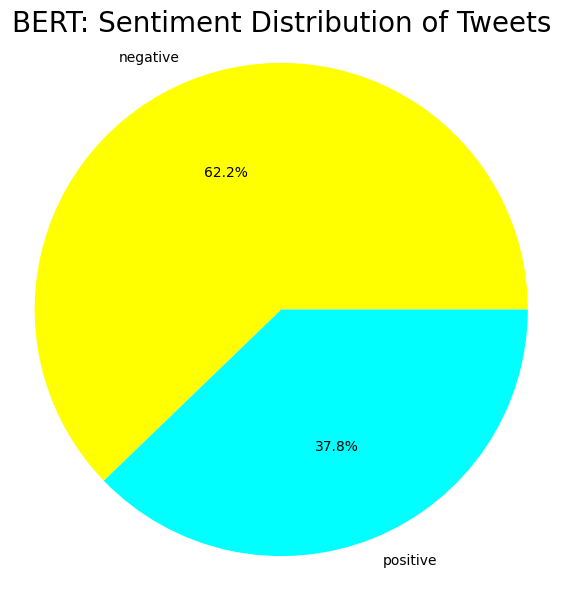

,index,sentiment_bert
0,negative,12733
1,positive,7732


In [ ]:
data_pie=tweets["sentiment_bert"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["yellow","cyan","pink"]
plt.pie(data_pie["sentiment_bert"],labels=data_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("BERT: Sentiment Distribution of Tweets", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
data_pie

In [ ]:
tweets[['date', 'text', 'sentiment_kmeans', 'sentiment_vader', 'sentiment_bert']]

,date,text,sentiment_kmeans,sentiment_vader,sentiment_bert
0,2023-04-12 20:05:08+00:00,@100xAltcoinGems @NeuroniAI $NEURONI\n\n Join our official Telegram group to stay tuned for the latest Neuroni AI updates and news. \n⪼ @NeuroniAI\n \n#AI #GPT4 #506x #NeuroniAI #Neuroni,negative,positive,negative
1,2023-04-12 20:05:06+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Invest in $NEURONI and be part of our project reserve, with a total supply of 10M tokens and no dev tokens. \n⪼ @NeuroniAI\n \n#AI #GPT4 #504x #NeuroniAI #Neuroni",negative,neutral,negative
2,2023-04-12 20:05:04+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Get ready for Neuroni AI Bot, available for free with all its features until Phase 3 of our roadmap. \n⪼ @NeuroniAI\n \n#AI #GPT4 #502x #NeuroniAI #Neuroni",negative,positive,negative
3,2023-04-12 20:05:02+00:00,"@100xAltcoinGems @NeuroniAI $NEURONI\n\n Want Neuroni AI in your Telegram group? Choose our Premium subscription for unlimited requests, priority access to updates, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #500x #NeuroniAI #Neuroni",negative,positive,negative
4,2023-04-12 20:04:58+00:00,"@100xAltcoinGems $NEURONI\n\n Discover the latest Neuroni AI functions, including moderation for Telegram groups, premium user options, and more. \n⪼ @NeuroniAI\n \n#AI #GPT4 #455x #NeuroniAI #Neuroni \nhttps://t.co/MTWGnV6z9J",negative,neutral,negative
...,...,...,...,...,...
28705,2023-03-14 13:18:03+00:00,#gpt4 also #brootswasright https://t.co/tMTUiNqzcV,neutral,neutral,positive
28706,2023-03-14 13:03:11+00:00,"How much energy does it take to train #GPT4, the most powerful language model ever? \n\nAnd what does it mean for the planet? \n\n#AI #NLP #GPT4 #climate #ChatGPT #carbonfootprint \nhttps://t.co/VvOzp9BK06",neutral,positive,positive
28707,2023-03-14 12:45:23+00:00,It looks like VIDEO is dominating the GPT-4 polls. What do you think? #gpt4 https://t.co/Q1ABpeo3Dy,neutral,positive,negative
28708,2023-03-14 12:40:07+00:00,"The perfect storm is brewing, with the upcoming GPT-4 product launch backed by Titan developers and a diamond community. Jump in before the fomo begins #GPT4 \n\nhttps://t.co/kQv0gUU7wA",neutral,positive,positive


In [ ]:
# save the final dataset with all the results for future visualizations and analysis
#tweets.to_csv('tweetsGPT4sentiments_v3.csv', index=False)

### Calculate Cohen’s Kappa

In [3]:
# import the data with all the sentiment 
test = pd.read_csv('sentimentsTest_v3.csv')

In [4]:
len(test)

30

In [ ]:
test

In [ ]:
# remove all the neutral labeled tweets since BERT does not have that option, it will not be an accurate comparison otherwise 
tweets1 = tweets[tweets['sentiment_vader'].str.contains("positive|negative")==True]
tweets_noneutral = tweets1[tweets1['sentiment_kmeans'].str.contains("positive|negative")==True]
len(tweets_noneutral)

16176

In [ ]:
# take only the columns we need for evaluation: results columns
test = tweets_noneutral[['date', 'text', 'sentiment_kmeans', 'sentiment_vader', 'sentiment_bert']].sample(n=30, random_state=420)

In [ ]:
# turn all the sentiment words to numbers
def sentimentBack(score):
    if score == 'positive':
        return 1
    elif score == 'negative': 
        return -1
    else:
        return 0

In [ ]:
# apply the function from the previous cell to display the sentiment numbers instead of words for better interpretability by Cohens Kappa score
test['sentiment_kmeans']=test['sentiment_kmeans'].apply(sentimentBack)
test['sentiment_vader']=test['sentiment_vader'].apply(sentimentBack)
test['sentiment_bert']=test['sentiment_bert'].apply(sentimentBack)
test

In [ ]:
# manually insert the collected true labels from the team members
test["Abirami"] = [-1,-1,0,-1,0,1,-1,1,0,-1,-1,1,1,0,0,1,0,1,-1,1,0,-1,1,-1,0,1,-1,0,0,1]
test["Lahari"] = [1,-1,0,1,0,1,1,1,0,1,-1,1,1,0,0,1,0,1,1,1,0,-1,1,-1,0,1,1,0,0,1]
test["Venkata"] = [-1,-1,0,-1,0,1,-1,1,0,-1,-1,1,1,0,0,1,0,1,-1,1,0,-1,1,-1,0,1,-1,0,0,1]
test["Danila"] = [1,-1,1,1,1,1,1,1,0,0,-1,1,0,1,0,1,0,1,1,0,1,-1,1,0,0,-1,1,-1,1,0]
test

In [10]:
# this function takes the sentiment output in the form of (1, -1, 0) and calculates the average \
# we add up all the scores and see if the total stays positive, negative or neutral
def sentimentAvg(val1, val2, val3, val4):
    summ = val1 + val2 + val3 + val4
    if summ >= 1:
        return 1
    elif summ < 0: 
        return -1
    else:
        return 0

In [11]:
# map the sentiment average function onto team members' scores to get the team's average
test['team_avg'] = test.apply(lambda x: sentimentAvg(val1 = x['Abirami'], val2 = x['Lahari'], val3 = x['Venkata'], val4 = x['Danila']), axis=1)
test.head(5)

,date,text,sentiment_kmeans,sentiment_vader,sentiment_bert,Abirami,Lahari,Venkata,Danila,team_avg
0,2023-03-14 18:14:26+00:00,Do you know that ChatGPT can speak multiple la...,-1,1,-1,-1,1,-1,1,0
1,2023-03-21 23:23:08+00:00,"#GPT4 has only been out a week, and it's alrea...",1,-1,-1,-1,-1,-1,-1,-1
2,2023-03-28 14:24:57+00:00,Even without visual input the Blender-GPT add-...,-1,1,1,0,0,0,1,1
3,2023-03-28 16:36:21+00:00,#ChatGPT can triple productivity.🦾🧠 Are you re...,-1,1,1,-1,1,-1,1,0
4,2023-04-08 22:52:49+00:00,3/ 🤖 Witness the alliance of @Microsoft &amp; ...,-1,1,1,0,0,0,1,1


In [ ]:
#test.to_csv('sentimentsTest_v3.csv', index=False)

In [16]:
from sklearn.metrics import cohen_kappa_score

#define array of ratings for both raters
rater1 = test['sentiment_kmeans']
rater2 = test['sentiment_bert']
rater3 = test['sentiment_vader']
rater4 = test['Abirami']
rater5 = test['Lahari']
rater6 = test['Venkata']
rater7 = test['Danila']
rater8 = test['team_avg']


#calculate Cohen's Kappa

# K-Means vs true labels
score1 = cohen_kappa_score(rater1, rater2)
score2 = cohen_kappa_score(rater1, rater3)
score3 = cohen_kappa_score(rater1, rater4)
score4 = cohen_kappa_score(rater1, rater5)
score5 = cohen_kappa_score(rater1, rater6)
score6 = cohen_kappa_score(rater1, rater7)
score65 = cohen_kappa_score(rater1, rater8)

# BERT vs true labels
score7 = cohen_kappa_score(rater2, rater4)
score8 = cohen_kappa_score(rater2, rater5)
score9 = cohen_kappa_score(rater2, rater6)
score10 = cohen_kappa_score(rater2, rater7)
score11 = cohen_kappa_score(rater2, rater8)

In [17]:
# cretae a results table using Cohens Kappa scores from the previous cell
df_eval1 = pd.DataFrame(columns=['K-Means vs', 'Cohens Kappa Score'])
df_eval1['K-Means vs'] = ['BERT', 'Vader', 'Abirami', 'Lahari', 'Venkata', 'Danila', 'Team Average']
df_eval1['Cohens Kappa Score'] = [score1,score2,score3,score4,score5,score6, score65]
df_eval1

,K-Means vs,Cohens Kappa Score
0,BERT,-0.153846
1,Vader,0.037736
2,Abirami,0.050000
3,Lahari,-0.045455
4,Venkata,0.050000
5,Danila,0.062500
6,Team Average,0.000000


In [20]:
# save the results table for Kmeans
#df_eval1.to_csv('eval_table1.csv', index=False)

In [19]:
df_eval2 = pd.DataFrame(columns=['BERT vs', 'Cohens Kappa Score'])
df_eval2['BERT vs'] = ['Abirami', 'Lahari', 'Venkata', 'Danila', 'Team Average']
df_eval2['Cohens Kappa Score'] = [score7,score8,score9,score10,score11]
df_eval2

,BERT vs,Cohens Kappa Score
0,Abirami,0.000000
1,Lahari,0.017857
2,Venkata,0.000000
3,Danila,0.078341
4,Team Average,0.061033


In [ ]:
# save the results for the BERT table
#df_eval2.to_csv('eval_table2.csv', index=False)